In [1]:
#%display plain
%display latex

In [2]:
from matplotlib import cm
import numpy as np
import itertools
from itertools import combinations
from __future__ import print_function

In [3]:
real_vars = var('r,t,theta,phi,x,y,z')
for rv in real_vars:
    assume(rv, 'real')

In [4]:
xs = var(['x{}'.format(n) for n in range(3)])
for xi in xs: assume(xi,'real')

ys = var(['y{}'.format(n) for n in range(2)])
for yi in ys: assume(yi,'real')

xs, ys

((x0, x1, x2), (y0, y1))

In [5]:
p1 = sum([xi   for xi in xs])
p2 = sum([xi^2 for xi in xs])
p3 = sum([xi^3 for xi in xs])
p4 = sum([xi^4 for xi in xs])
p5 = sum([xi^5 for xi in xs])

p1, p2, p3, p4, p5

(x0 + x1 + x2,
 x0^2 + x1^2 + x2^2,
 x0^3 + x1^3 + x2^3,
 x0^4 + x1^4 + x2^4,
 x0^5 + x1^5 + x2^5)

In [6]:
e1 = sum([ xi             for (xi,           ) in combinations(xs,1)])
e2 = sum([ xi*xj          for (xi,xj         ) in combinations(xs,2)])
e3 = sum([ xi*xj*xk       for (xi,xj,xk      ) in combinations(xs,3)])

e1, e2, e3

(x0 + x1 + x2, x0*x1 + x0*x2 + x1*x2, x0*x1*x2)

In [7]:
def inner_product(f,g,vrs):
    ip = (f.conjugate()*g).expand()*exp(-sum([vi^2 for vi in vrs]))/(2*pi)^len(vrs)
    # odd parts will integrate out, so remove them. makes this go quite a bit faster
    for vi in vrs:
        ip = ((ip+ip(vi=-vi))/2).simplify_full()
    for vi in vrs:
        ip = integrate(ip,vi,-oo,oo)
    return ip

In [8]:
com = vector([1,1,1])/sqrt(3) # center of mass

j1 = vector(QQ,[1,0,0])
j2 = vector(QQ,[0,1,0])

j1 = j1 - (j1*com)*com/com.norm()^2
j2 = j2 - (j2*com)*com/com.norm()^2

j2 = j2 - (j2*j1)*j1/j1.norm()^2

j1 = j1/j1.norm()
j2 = j2/j2.norm()

In [9]:
Pm = matrix([com,j1,j2]).transpose()

Qm = matrix([[0,0],
             [1,0],
             [0,1]])

In [10]:
threebody_mats = [
    # 012
    matrix([[1,-1, 0],
            [0, 1,-1]])
]

Pl = matrix([j1,j2]).transpose()

def orthogonalize_rows(M):
    rows = list(M)
    for idx in range(len(rows)):
        rows[idx] = (rows[idx]/rows[idx].norm()).simplify_full()
        for idx2 in range(idx+1,len(rows)):
            rows[idx2] = rows[idx2] - (rows[idx2]*rows[idx])*rows[idx]
    return matrix(rows)
    
# the (3 choose 3) 3-body interations in 3 dimensions
tbi3s = [ M.right_kernel().basis_matrix() for M in threebody_mats ]
tbi3s = [ orthogonalize_rows(M) for M in tbi3s]

# the (3 choose 3) 3-body interations in 2 dimensions -- null
tbi2s = [ (M*Pl).right_kernel().basis_matrix() for M in threebody_mats ]
tbi2s = [ orthogonalize_rows(M) for M in tbi2s]

In [11]:
f1 = e1(*(Pm*Qm*vector(ys))).simplify_full()
f2 = e2(*(Pm*Qm*vector(ys))).simplify_full()
f3 = e3(*(Pm*Qm*vector(ys))).simplify_full()

f1, f2, f3

(0, -1/2*y0^2 - 1/2*y1^2, 1/18*sqrt(3)*(sqrt(2)*y0^3 - 3*sqrt(2)*y0*y1^2))

In [12]:
def stereographic_proj(v):
    """ Standard Stereographic projection with possible pre-rotation about X, Y and Z axis"""
    w = vector(v)
    return (w[0]/(1-w[2]),w[1]/(1-w[2]))

def to_iso_spherical_coords(v):
    x, y, z = v
    r = sqrt(x^2+y^2+z^2)
    theta = arccos(z/r)
    phi = atan2(y,x)
    return (r,theta,phi)

def to_iso_sphere_coords(v):
    r, theta, phi = to_iso_spherical_coords(v)
    return (phi, theta) #(theta, phi)

In [13]:
def legendre_poly(n):
    return diff( (x^2-1)^n, x, n)/(2^n*factorial(n))

def assoc_legendre_poly(m,l):
    if m >= 0:
        return (-1)^m * (1-x^2)^(m/2) *diff(legendre_poly(l),x,m)
    else:
        return (-1)^m * factorial(l-m) /factorial(l+m) * assoc_legendre_poly(-m,l)

def real_sh(m,l):
    return r^(l)*cos(m*phi)*assoc_legendre_poly(m,l)(x=cos(theta))

def imag_sh(m,l):
    return r^(l)*sin(m*phi)*assoc_legendre_poly(m,l)(x=cos(theta))

def polar_to_euclid(f):
    return ( f(theta=arccos(y2/r)) )(r=sqrt(y0^2+y1^2+y2^2), phi=atan2(y1,y0))

def euclid_real(m,l):
    return polar_to_euclid(real_sh(m,l)).simplify()

def euclid_imag(m,l):
    return polar_to_euclid(imag_sh(m,l)).simplify()

def euclid_to_sphere(f):
    return f(y0=r*sin(theta)*cos(phi),y1=r*sin(theta)*sin(phi),y2=r*cos(theta))

In [14]:
def lap(f,vrs):
    """ laplacian """
    return sum([diff(f,vi,2) for vi in vrs])

def rep_lap(f,k,vrs):
    """ repeated laplacian  """
    if k <= 0:
        return f
    elif k == 1:
        return lap(f,vrs)
    else:
        return lap(rep_lap(f,k-1,vrs),vrs)
    
def semi_factorial(n):
    """ product: n*(n-2)*(n-4)*...*1 """
    if n <= 1:
        return 1
    else:
        return n*semi_factorial(n-2)
    
def harmonic_leading_term(f,n,vrs):
    """ as in (1-33), pg 8 of Avery's Hyperspherical Harmonics, Applications in Quantu Theory """
    r_sq = sum([vi^2 for vi in vrs])
    d = len(vrs)
    return sum([ ((-1)^k)*semi_factorial(d+2*n-2*k-4) \
                / ( semi_factorial(2*k) * semi_factorial(d+2*n-4) ) \
                * (r_sq^k) * rep_lap(f,k,vrs) for k in range(floor(n/2)+1)])

In [25]:
# a harmonic symmetric function of degree 2 in 3 variables
sym_fn_2 = 0
ell = 2
for vec in [vector([1,1,1])]:
    sym_fn_2 += (r^ell*gegenbauer(ell,3/2-1,
                                  (vec/norm(vec))*(vector(xs)/norm(vector(xs)))))\
    (r=sqrt(sum([xi^2 for xi in xs]))).simplify_full()

# check symmetry
assert (sym_fn_2(x0=x1,x1=x0)-sym_fn_2).expand() == 0
assert (sym_fn_2(x0=x2,x2=x0)-sym_fn_2).expand() == 0

# is harmonic
assert lap(sym_fn_2,xs).simplify_full() == 0

sym_fn_2.expand()

x0*x1 + x0*x2 + x1*x2

In [48]:
# a harmonic symmetric function of degree 3 in 3 variables
sym_fn_3 = 0
ell = 3
for vec in list(identity_matrix(3)):
    sym_fn_3 += (r^ell*gegenbauer(ell,3/2-1,
                                  (vec/norm(vec))*(vector(xs)/norm(vector(xs)))))\
    (r=sqrt(sum([xi^2 for xi in xs]))).simplify_full()

# check symmetry
assert (sym_fn_3(x0=x1,x1=x0)-sym_fn_3).expand() == 0
assert (sym_fn_3(x0=x2,x2=x0)-sym_fn_3).expand() == 0

# is harmonic
assert lap(sym_fn_3,xs).simplify_full() == 0

sym_fn_3.expand()

x0^3 - 3/2*x0^2*x1 - 3/2*x0*x1^2 + x1^3 - 3/2*x0^2*x2 - 3/2*x1^2*x2 - 3/2*x0*x2^2 - 3/2*x1*x2^2 + x2^3

In [49]:
factor(sym_fn_3)

x0^3 - 3/2*x0^2*x1 - 3/2*x0*x1^2 + x1^3 - 3/2*x0^2*x2 - 3/2*x1^2*x2 - 3/2*x0*x2^2 - 3/2*x1*x2^2 + x2^3

In [50]:
def rotation_matrix(theta):
    return matrix([[cos(theta), -sin(theta)],
                   [sin(theta),  cos(theta)]])

wv = sym_fn_3(*(Pm*Qm*rotation_matrix(pi/4)*vector(ys))).simplify_full().expand()

wv

-5/12*sqrt(3)*y0^3 - 5/4*sqrt(3)*y0^2*y1 + 5/4*sqrt(3)*y0*y1^2 + 5/12*sqrt(3)*y1^3

In [51]:
(3*4*wv/sqrt(3)/5).expand()

-y0^3 - 3*y0^2*y1 + 3*y0*y1^2 + y1^3

In [57]:
tbc = (18*wv(*(rotation_matrix(0)*vector(ys)))/sqrt(3)).expand().simplify_full().expand()

tbc

-15/2*y0^3 - 45/2*y0^2*y1 + 45/2*y0*y1^2 + 15/2*y1^3

In [58]:
plot3d( tbc, (y0,-1,1), (y1,-1,1))

Graphics3d Object

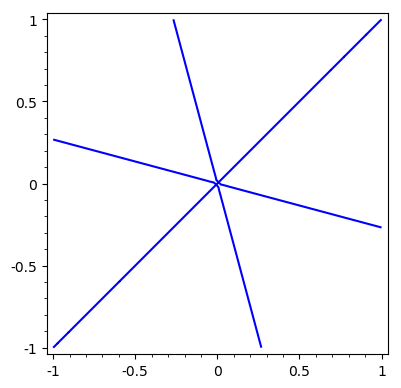

In [59]:
implicit_plot( tbc, (y0,-1,1), (y1,-1,1))

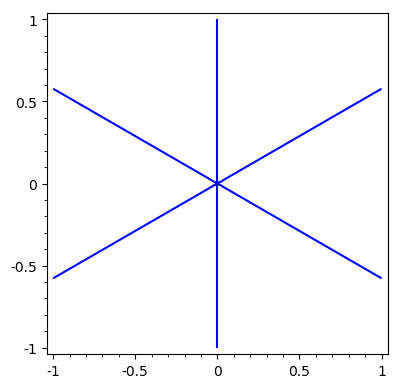

In [60]:
implicit_plot( f3, (y0,-1,1), (y1,-1,1))